## Crystal hardness

The energy of a crystal varies with the volume of the unit cell. The equilibrium volume is found at the minimum in the potential energy surface. The shape of this curve can be described by an equation of state, where energy is a function of volume or pressure, i.e. $E(V)$ or $E(P)$. The curvature is related to the bulk modulus $B$, which can be defined as:

$
B = -V \frac{\partial P}{\partial V} = V \frac{\partial^2 E}{\partial V^2}
$

The typical unit of $B$ is GPa. For example, diamond has has a measured bulk modulus of $B$ = 443 GPa at T = 4 K. The bulk modulus is a useful quantity in models of materials bonding, thermodynamics, and mechanics. For instance, the inverse of the bulk modulus is the compressability of a crystal ($\kappa = \frac{1}{B}$).

The Python package `matminer` (https://matminer.readthedocs.io) is used to access the materials dataset and featurise the data in a form that is suitable for statistical analysis and building machine learning models. The Python package `pymatgen` (https://pymatgen.org) is used to power the [Materials Project](https://materialsproject.org).

In [ ]:
# Installation of libraries
%pip install matminer --quiet

In [ ]:
# Basic utilities
import pprint  # Pretty print data structures
import warnings  # Warning control
import numpy as np
from numpy.exceptions import ComplexWarning  # Warning for complex numbers

# Data handling
import pandas as pd
from monty.serialization import loadfn  # Load serialised data

# Materials science
from pymatgen.core import Structure  # Materials analysis for crystal structures
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materials datasets

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Warning management
warnings.filterwarnings('ignore', category=ComplexWarning)  # Ignore ComplexWarning

## Bulk moduli dataset

From `matminer`, what datasets are available can be checked using the `datasets.get_available_datasets()` method.

In [ ]:
# Print the available datasets
matminer.datasets.get_available_datasets(print_format='low')

The `get_all_dataset_info` function from the `matminer.datasets.dataset_retrieval` module is used to output a detailed description of a matminer dataset.

In [5]:
# Check the information for the "matbench_log_kvrh" dataset
print(matminer.datasets.dataset_retrieval.get_all_dataset_info('matbench_log_kvrh'))
# Here "K" relates to the bulk modulus , and "VRH" relates to the Voigt-Reuss-Hill equation of state.

Dataset: matbench_log_kvrh
Description: Matbench v0.1 test dataset for predicting DFT log10 VRH-average bulk modulus from structure. Adapted from Materials Project database. Removed entries having a formation energy (or energy above the convex hull) more than 150meV and those having negative G_Voigt, G_Reuss, G_VRH, K_Voigt, K_Reuss, or K_VRH and those failing G_Reuss <= G_VRH <= G_Voigt or K_Reuss <= K_VRH <= K_Voigt and those containing noble gases. Retrieved April 2, 2019. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	log10(K_VRH): Target variable. Base 10 logarithm of the DFT Voigt-Reuss-Hill average bulk moduli in GPa.
	structure: Pymatgen Structure of the material.
Num Entries: 10987
Reference: Jong, M. De, Chen, W., Angsten, T., Jain, A., Notestine, R., Gamst,
A., Sluiter, M., Ande, C. K., Zwaag, S. Van Der, Plata, J. J., Toher,
C., Curtarol

In [11]:
# Use matminer to download the dataset
df = load_dataset('matbench_log_kvrh')
print(f'The full dataset contains {df.shape[0]} entries. \n')

# Store the original DataFrame as a copy
full_dataset_df = df.copy()
# Create a subset of the original DataFrame for demonstration purposes
df = df.sample(n=1500, random_state=412)

print('The DataFrame is shown below:')
df.head(10)

The full dataset contains 10987 entries. 

The DataFrame is shown below:


,structure,log10(K_VRH)
1522,"[[0. 0. 0.] Al, [1.5033628 1.5033628 1.5033628...",2.292256
6398,"[[0. 0. 0.] Ca, [1.48173761 1.04774663 2.56644...",1.939519
4609,"[[2.69710348 1.65076684 1.18744341] P, [0.8990...",2.240549
115,"[[3.17206338 0.74565987 5.45159639] Na, [5.342...",1.579784
4143,"[[0. 0. 0.] Mg, [-1.96703827e-08 2.65624033e+...",1.623249
6083,"[[3.43133549 3.43133549 3.43133549] Dy, [0. 0....",2.017033
9308,"[[3.33064489 3.33064489 6.76736121] Th, [1.110...",1.838849
8972,"[[0. 0. 0.] In, [0. 2.04359843 2.04359...",2.149219
311,"[[0. 0. 0.] Yb, [-5.45694216e+00 1.86496845e-...",1.832509
8505,"[[0. 0. 0.] Mn, [-4.39799961 -4.39799961 -4.39...",2.049218


`df.describe()` is used to summary statistics of the numerical columns. The importance of this is to check whether the data for our target variable, `log10(K_VRH)`, is reasonable. Negative values for the bulk modulus are considered unphysical and forbidden by crystal thermodynamics.

From the summary statistics, the minimum value for `log10(K_VRH)` is zero, so it appears that there are no glaring issues with the target variable.

In [12]:
df.describe()

,log10(K_VRH)
count,1500.000000
mean,1.876116
std,0.363554
min,0.477121
25%,1.672098
50%,1.929419
75%,2.158362
max,2.639486


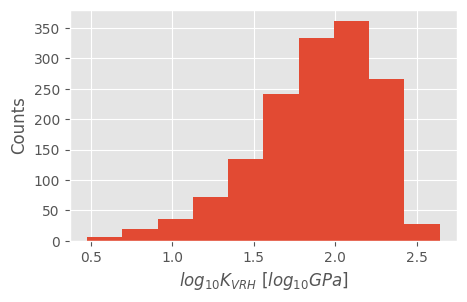

In [13]:
# Plot a histogram
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(df['log10(K_VRH)'])
ax.set_xlabel(r'$log_{10}K_{VRH}$ [$log_{10}GPa$]')
ax.set_ylabel('Counts')
plt.show()

## Features of materials
There are only one input feature, the crystal structure. This is not a numerical feature that can be used for a regression model. For supervised machine learning, we must represent each material by a vector that can be used as an input to the model, e.g.

$$f(\textrm{material}) \rightarrow [1.1,0.8,3.5,0.01]$$

### Composition-based features

To use the `ElementProperty` featuriser, `pymatgen.core.composition.Composition` object is needed to add a to DataFrame. 

In [15]:
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.structure.order import DensityFeatures

# Add a composition column to df using the composition property of the Structure class and a lambda function
df['composition'] = df.structure.apply(lambda x: x.composition )
df.head()

,structure,log10(K_VRH),composition
1522,"[[0. 0. 0.] Al, [1.5033628 1.5033628 1.5033628...",2.292256,"(Al, Rh)"
6398,"[[0. 0. 0.] Ca, [1.48173761 1.04774663 2.56644...",1.939519,"(Ca, In, Cu)"
4609,"[[2.69710348 1.65076684 1.18744341] P, [0.8990...",2.240549,"(P, Zr, Nb)"
115,"[[3.17206338 0.74565987 5.45159639] Na, [5.342...",1.579784,"(Na, O, P, S)"
4143,"[[0. 0. 0.] Mg, [-1.96703827e-08 2.65624033e+...",1.623249,"(Mg, Sb)"


The new composition column contains both the elements and the amount of each element in the composition.
`ElementProperty` featuriser is used to add some composition-based features to dataset.

In [16]:
# Create the ElementProperty featuriser
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')

# By default multiprocessing is enabled, however this has been known to slow performance on some systems, so we disable it
el_prop_featuriser.set_n_jobs(1)

# Apply the ElementProperty featuriser
df = el_prop_featuriser.featurize_dataframe(df, col_id='composition')

# Print the shape of the DataFrame
print(df.shape)
df.head()

c:\Users\willy\AppData\Local\Programs\Python\Python313\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/1500 [00:00<?, ?it/s]

(1500, 135)


,structure,log10(K_VRH),composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
1522,"[[0. 0. 0.] Al, [1.5033628 1.5033628 1.5033628...",2.292256,"(Al, Rh)",13.0,45.0,32.0,29.000000,16.000000,13.0,59.0,...,0.0,0.0,0.0,0.0,225.0,225.0,0.0,225.000000,0.000000,225.0
6398,"[[0. 0. 0.] Ca, [1.48173761 1.04774663 2.56644...",1.939519,"(Ca, In, Cu)",20.0,49.0,29.0,30.833333,6.055556,29.0,7.0,...,0.0,0.0,0.0,0.0,139.0,225.0,86.0,210.666667,23.888889,225.0
4609,"[[2.69710348 1.65076684 1.18744341] P, [0.8990...",2.240549,"(P, Zr, Nb)",15.0,41.0,26.0,32.000000,11.333333,15.0,44.0,...,0.0,0.0,0.0,0.0,2.0,229.0,227.0,141.666667,93.111111,2.0
115,"[[3.17206338 0.74565987 5.45159639] Na, [5.342...",1.579784,"(Na, O, P, S)",8.0,16.0,8.0,11.000000,2.250000,8.0,2.0,...,0.0,0.0,0.0,0.0,2.0,229.0,227.0,99.375000,97.218750,12.0
4143,"[[0. 0. 0.] Mg, [-1.96703827e-08 2.65624033e+...",1.623249,"(Mg, Sb)",12.0,51.0,39.0,27.600000,18.720000,12.0,68.0,...,0.0,0.0,0.0,0.0,166.0,194.0,28.0,182.800000,13.440000,194.0


In [17]:
# Check the reference for a property featuriser
el_prop_featuriser.citations()

['@article{ward_agrawal_choudary_wolverton_2016, title={A general-purpose machine learning framework for predicting properties of inorganic materials}, volume={2}, DOI={10.1038/npjcompumats.2017.28}, number={1}, journal={npj Computational Materials}, author={Ward, Logan and Agrawal, Ankit and Choudhary, Alok and Wolverton, Christopher}, year={2016}}']

### Structure-based features

Within `matminer`, there are many featurisers which operate on crystal structures. Some simple features based on the density of the structures can be added using `DensityFeatures`.

In [18]:
# Crystal structure to vector
density_featuriser = DensityFeatures()
density_featuriser.set_n_jobs(1)
df=density_featuriser.fit_featurize_dataframe(df, col_id='structure')

df.head()

DensityFeatures:   0%|          | 0/1500 [00:00<?, ?it/s]

,structure,log10(K_VRH),composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction
1522,"[[0. 0. 0.] Al, [1.5033628 1.5033628 1.5033628...",2.292256,"(Al, Rh)",13.0,45.0,32.0,29.000000,16.000000,13.0,59.0,...,0.0,225.0,225.0,0.0,225.000000,0.000000,225.0,7.934755,13.590999,0.680128
6398,"[[0. 0. 0.] Ca, [1.48173761 1.04774663 2.56644...",1.939519,"(Ca, In, Cu)",20.0,49.0,29.0,30.833333,6.055556,29.0,7.0,...,0.0,139.0,225.0,86.0,210.666667,23.888889,225.0,7.103732,15.937476,0.849691
4609,"[[2.69710348 1.65076684 1.18744341] P, [0.8990...",2.240549,"(P, Zr, Nb)",15.0,41.0,26.0,32.000000,11.333333,15.0,44.0,...,0.0,2.0,229.0,227.0,141.666667,93.111111,2.0,6.893887,17.270800,0.628370
115,"[[3.17206338 0.74565987 5.45159639] Na, [5.342...",1.579784,"(Na, O, P, S)",8.0,16.0,8.0,11.000000,2.250000,8.0,2.0,...,0.0,2.0,229.0,227.0,99.375000,97.218750,12.0,2.410668,15.499203,0.680511
4143,"[[0. 0. 0.] Mg, [-1.96703827e-08 2.65624033e+...",1.623249,"(Mg, Sb)",12.0,51.0,39.0,27.600000,18.720000,12.0,68.0,...,0.0,166.0,194.0,28.0,182.800000,13.440000,194.0,3.936736,26.694842,0.509099


## Bulk modulus regression

With regression tasks, `scikit-learn` is used to fit a model that maps input feature $x$ to our target variable $y$, i.e. $y=f(x)$. For this task, the target variable is `log(K_VRH)`, which will be predicted from knowledge of the composition and structure (represented by the set of chosen features).

Extensive use of [scikit-learn] can be found in https://scikit-learn.org.

### Data preparation

To start, any non-numerical data including the target variable `log10(K_VRH) must be removed.

In [19]:
# Define the features we want to keep
features_to_drop = ['structure','composition','log10(K_VRH)']
feature_cols = [col for col in list(df.columns) if col not in features_to_drop]

# Get an array of the features
X = df[feature_cols].values

# Get an array of the target variable
y = df['log10(K_VRH)'].values

print(f'There are {len(feature_cols)} features in the dataset.')
print(feature_cols)

There are 135 features in the dataset.
['MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData minimum Column', 'MagpieData maximum Column', 'MagpieData range Column', 'MagpieData mean Column', 'MagpieData avg_dev Column', 'MagpieData mode Column', 'MagpieData minimum Row', 'M

### Baseline linear regression model

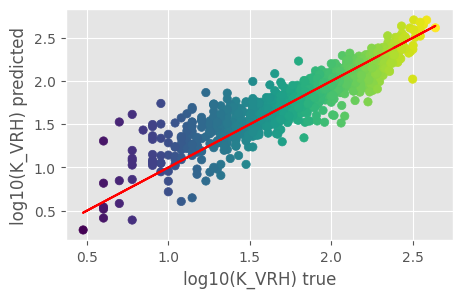

In [20]:
# Import linear regression model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit the model to the data
lr = LinearRegression()
lr.fit(X, y)

def make_prediction_plot(X, y, model, label):
    """
    Plot and return predictions for the given model and data.

    Parameters:
    X : Input features.
    y : Actual target values.
    model : Fitted model.
    label : Descriptor for the axes labels.

    Returns:
    Predicted values.
    """
    y_pred = model.predict(X)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(y, y_pred, c=y, cmap='viridis')
    ax.plot(y, y, 'r-')
    ax.set_xlabel(f'{label} true')
    ax.set_ylabel(f'{label} predicted')
    plt.show()

    return y_pred

# Make predictions using the fitted model
y_pred = make_prediction_plot(X, y, lr, 'log10(K_VRH)')

In [21]:
from sklearn import metrics

# Mean absolute error
print (f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')

# Mean squared error
print(f'The training RMSE = {metrics.root_mean_squared_error(y,y_pred):.3f} log10GPa')

# $r^2$ - coefficient of determination
print(f'The training r^2 = {lr.score(X,y):.3f}')

The training MAE = 0.093 log10GPa
The training RMSE = 0.139 log10GPa
The training r^2 = 0.853


### Random forest regressor

[Random forest](https://en.wikipedia.org/wiki/Random_forest) is an ensemble machine learning algorithm that combines multiple [decision trees](https://en.wikipedia.org/wiki/Decision_tree) to improve predictive accuracy.

Random forest can be applied to both classification and regression tasks. The prediction is made by taking a majority vote (for classification) or averaging (for regression) of the predictions from individual trees. Mathematically, it can be represented as:

$
\hat{y}_{RF} = \frac{1}{n_{trees}} \sum_{i=1}^{n_{trees}} f_i(x)
$

where:
- $\hat{y}_{RF}$ is the random forest prediction.
- $n_{trees}$ is the number of decision trees in the forest.
- $f_i(x)$ represents the prediction of the $i$-th tree.

In `sklearn`, the random forest regressor is created by:

```python
RandomForestRegressor(n_estimators=<int>, criterion=<str>, max_depth=<int>, min_samples_split=<int>, min_samples_leaf=<int>)
```

The hyperparameters that need to be set are:
* `n_estimators`: number of decision trees in the random forest model.
* `criterion`: loss function to be minimised. Default value is 'squared_error` which is the MSE.
* `max_depth`: maximum depth of the tree.
* `min_sample_split`: minimum number of samples required to split an internal node.
* `min_samples_leaf`: minimum number of samples required to be at a leaf node.

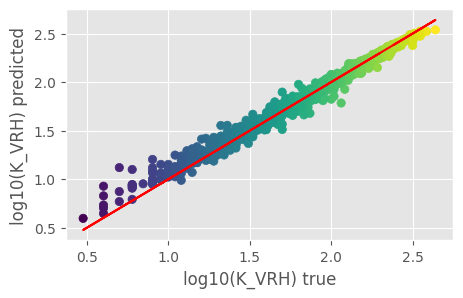

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(n_estimators=100,criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=412)

# Fit the model
rf.fit(X,y)

y_pred_rf = make_prediction_plot(X,y,rf,'log10(K_VRH)')

In [26]:
# Print the metrics
print(f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')
print(f'The training RMSE = {metrics.root_mean_squared_error(y,y_pred):.3f} log10GPa')
print(f'The training r^2 = {rf.score(X,y):.3f}')

The training MAE = 0.033 log10GPa
The training RMSE = 0.052 log10GPa
The training r^2 = 0.980


## Cross validation
To better determine the quality of our model, cross-validation (CV) is used to evaluate the out-of-sample goodness-of-fit of a regressor. $k$-fold CV means that the training set is splited into $k$ subsets. Each subset is used as a validation set to evaluate the performance, with the model being trained on the remaining $k-1$ subsets.

In [38]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

# Define the number of splits for cross-validation
n_splits = 5

# Compute the cross-validation score
cv = KFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=412
    )

scores= cross_val_score(rf, X, y,cv=cv, scoring='neg_mean_absolute_error')

r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')

print('From our cross-validation, we have obtained the following results:')
print(f'mean MAE = {np.mean(np.abs(scores)):.3f} log10GPa')
print(f'mean r^2 = {np.mean(np.abs(r2_scores)):.3f}')

From our cross-validation, we have obtained the following results:
mean MAE = 0.091 log10GPa
mean r^2 = 0.853


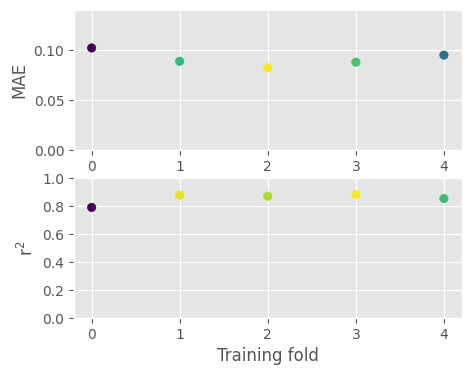

In [39]:
# Show the training scores for each k-fold
fig, ax = plt.subplots(2, 1, figsize=(5, 4))

ax[0].scatter([i for i in range(len(scores))], np.abs(scores), c=scores, cmap='viridis')
ax[1].scatter([i for i in range(len(r2_scores))], np.abs(r2_scores), c=r2_scores, cmap='viridis')
ax[0].set_xlabel('Training fold')
ax[0].set_ylabel('MAE')
ax[0].set_ylim(0, 0.14)
ax[0].set_xticks(range(len(scores)))
ax[1].set_xticks(range(len(r2_scores)))
ax[1].set_xlabel('Training fold')
ax[1].set_ylabel('r$^2$')
ax[1].set_ylim(0, 1.0)

# Display the plot
plt.show()

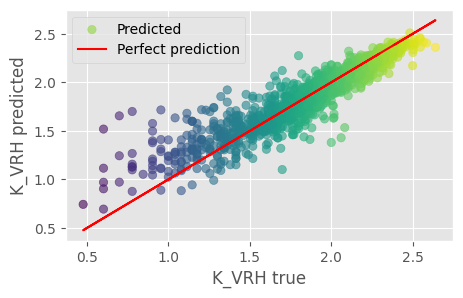

In [40]:
from sklearn.model_selection import cross_val_predict

# Plot the original and predicted data against each other
fig, ax = plt.subplots(figsize=(5, 3))

# Scatter plot with color
ax.scatter(y, cross_val_predict(rf, X, y, cv=cv), c=y, cmap='viridis', label='Predicted', alpha=0.6)

# Red line representing a perfect prediction (y = x)
ax.plot(y, y, 'r-', label='Perfect prediction')

# Set labels and legend
ax.set_xlabel('K_VRH true')
ax.set_ylabel('K_VRH predicted')
ax.legend()

plt.show()

## Feature importance

Through finding which materials features were most useful will increase our understanding (the interpretability) of the model. How particular features contribute to a Random Forest model can be known by looking at the `RandomForestRegressor().feature_importances_` attribute.

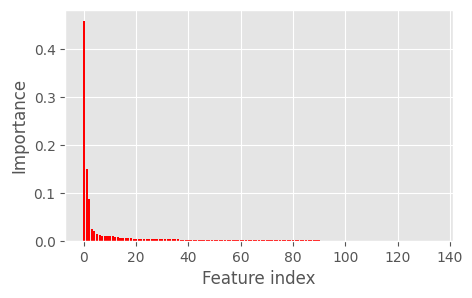

In [41]:
# Get the feature importances
importances = rf.feature_importances_

# Get the indices that would sort the importances array from largest to smallest
indices = np.argsort(importances)[::-1]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the feature importance
ax.bar(range(X.shape[1]), importances[indices], color="r", align="center") # When x=0, height=importances[indices][0]...

# Set the labels
ax.set_xlabel("Feature index")
ax.set_ylabel("Importance")

plt.show()

There is a rapid drop off in the feature importance, with few features offering a significant contribution to the model.

C:\Users\willy\AppData\Local\Temp\ipykernel_5928\20203713.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_feature_names, rotation=45, ha='right', rotation_mode='anchor')


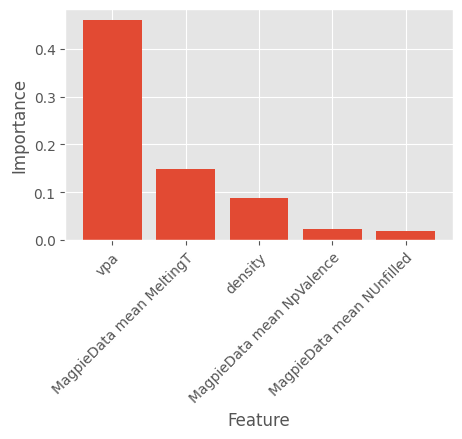

Top 5 Features:
    1. vpa (0.460)
    2. MagpieData mean MeltingT (0.150)
    3. density (0.088)
    4. MagpieData mean NpValence (0.024)
    5. MagpieData mean NUnfilled (0.019)


In [42]:
# Visualise the top N features
N = 5

# Get the names of the top N important features
top_feature_names = df[feature_cols].columns.values[np.argsort(importances)[::-1][:N]] # feature_cols is from Bulk modulus regression/Data preparation 

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the top N feature importances
ax.bar(x=top_feature_names, height=importances[np.argsort(importances)[::-1][:N]])

# Set the labels and title
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")

# Rotate x-axis labels for better readability
ax.set_xticklabels(top_feature_names, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

# Print them too
print(f"Top {N} Features:")
for feat in range(N):
    print(f"    {feat+1}. {feature_cols[indices[feat]]} ({importances[indices[feat]]:.3f})")

In [43]:
# Evaluate the prediction of the top-5 most important features

cols_top5 = [feature_cols[i] for i in indices[:5]]
X_top5 = df[cols_top5].values
y = df['log10(K_VRH)'].values

rf_top5 = RandomForestRegressor(n_estimators=100,criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=412)
rf_top5.fit(X_top5, y)

scores_top5 = cross_val_score(rf_top5, X_top5, y, cv=cv, scoring='neg_mean_absolute_error')
r2_scores_top5 = cross_val_score(rf_top5, X_top5, y, scoring='r2')

scores= cross_val_score(rf, X, y,cv=cv, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')

print('From cross-validation:')
print(f'mean MAE = {np.mean(np.abs(scores)):.3f} log10GPa')
print(f'mean MAE for top 5 features = {np.mean(np.abs(scores_top5)):.3f} log10GPa')
print(f'mean r^2 = {np.mean(np.abs(r2_scores)):.3f}')
print(f'mean r^2 for top 5 features = {np.mean(np.abs(r2_scores_top5)):.3f}')
print('The performance degradation after reducing the feature set to the top five is small, indicating that most of the predictive power is captured by a small number of physically meaningful descriptors.')


From cross-validation:
mean MAE = 0.091 log10GPa
mean MAE for top 5 features = 0.100 log10GPa
mean r^2 = 0.853
mean r^2 for top 5 features = 0.835
The performance degradation after reducing the feature set to the top five is small, indicating that most of the predictive power is captured by a small number of physically meaningful descriptors.
